In [10]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import json
import math
import requests
import numpy as np
import seaborn as sns
import matplotlib.pylab as pylab

params = {'legend.fontsize': '17',
          'figure.figsize': (20, 10),
         'axes.labelsize': '18',
         'axes.titlesize':'21',
         'xtick.labelsize':'17',
         'ytick.labelsize':'17'}
#pylab.rcParams.update(pylab.rcParamsDefault)
pylab.rcParams.update(params)

pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df_tests = pd.read_csv('data/test.psv', sep = '|', encoding = 'unicode_escape')
df_vehicles = pd.read_csv('data/veh.psv', sep = '|', encoding = 'unicode_escape')
df_uk_accidents = pd.read_csv('data/uk_accidents.csv', encoding = 'unicode_escape')
df_uk_vehicles = pd.read_csv('data/uk_vehicles.csv', encoding = 'unicode_escape')
df_uk_casualties = pd.read_csv('data/uk_casualties.csv', encoding = 'unicode_escape')
df_uk_makes = pd.read_csv('data/Vehicle_Information.csv', usecols = [0, 10, 11, 19], encoding = 'unicode_escape')
df_matched_vehicles = pd.read_csv('matched_vehicles.csv', encoding = 'unicode_escape')

/home/tarek/L4L/.venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/tarek/L4L/.venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Appending makes and models to the UK vehicles DF
if 'Vehicle_Make' not in df_uk_vehicles:
    df_uk_vehicles = pd.merge(df_uk_vehicles, df_uk_makes, on = ['Accident_Index', 'Vehicle_Reference'], how='left')
    
# Rename vehicle make, model to follow the same convention
df_uk_vehicles.rename(columns={'make': 'Vehicle_Make', 'model': 'Vehicle_Model'}, inplace = True)


# Mapping numeric values to corresponding text
df_uk_vehicles_map = {
    'Engine_Capacity_(CC)': {-1: np.nan},
    'Sex_of_Driver': {-1: np.nan, 3: np.nan, 2: 'Female', 1: 'Male'},
    'Age_Band_of_Driver': {-1: np.nan, 1: '0-5', 2: '6-10', 3: '11-15', 4: '16-20', 5: '21-25', 6: '26-35', 7: '36-45', 8: '46-55', 9: '56-65', 10: '66-75', 11: 'Over 75'}, 
    'Vehicle_Make': {'MISSING': np.nan},
    'Vehicle_Model': {'MISSING': np.nan},
    'Age_of_Vehicle': {-1: np.nan},
    '1st_Point_of_Impact': {-1: np.nan, 1: 'Front', 2: 'Back', 3: 'Offside', 4: 'Nearside'},
    'Vehicle_Manoeuvre': {-1: np.nan, 1: 'Reversing', 2: 'Parked', 3: 'Waiting to go - held up', 4: 'Slowing or stopping', 5: 'Moving off', 6: 'U-turn', 7: 'Turning left', 8: 'Waiting to turn left', 9: 'Turning right', 10: 'Waiting to turn right', 11: 'Changing lane to left', 12: 'Changing lane to right', 13: 'Overtaking moving vehicle – offside', 14: 'Overtaking static vehicle - offside', 15: 'Overtaking - nearside', 16: 'Going ahead left-hand bend', 17: 'Going ahead right-hand bend', 18: 'Going ahead other'},
    'Vehicle_Type': {-1: np.nan, 90: np.nan, 1: 'Pedal cycle', 2: 'Motorcycle <=50cc', 3: 'Motorcycle <=125cc', 4: 'Motorcycle 125cc-500cc', 5: 'Motorcycle >500cc', 8: 'Taxi/Private hire car', 9: 'Car', 10: 'Minibus (8-16 seats)', 11: 'Bus (>=17 seats)', 16: 'Ridden horse', 17: 'Agricultural vehicle', 18: 'Tram', 19: 'Van <=3.5 t.', 20: 'Goods 3.5t.-7.5t', 21: 'Goods >=7.5 t.', 22: 'Mobility scooter', 23: 'Electric motorcycle', 97: 'Motorcycle - unknown cc', 98: 'Goods vehicle - unknown weight'}
}
df_uk_accidents_map = {
    'Accident_Severity': {-1: np.nan, 1: 'Fatal', 2: 'Serious', 3: 'Slight'},
    'Weather_Conditions': {-1: np.nan, 8: np.nan, 9: np.nan, 1: 'Fine no high winds', 2: 'Raining no high winds', 3: 'Snowing no high winds', 4: 'Fine + high winds', 5: 'Raining + high winds', 6: 'Snowing + high winds', 7: 'Fog or mist'},
    'Light_Conditions': {-1: np.nan, 1: 'Daylight', 4: 'Darkness - lights lit', 5: 'Darkness - lights unlit', 6: 'Darkness - no lighting', 7: 'Darkness - lighting unknown'}
}
df_uk_casualties_map = {
    'Casualty_Severity': {-1: np.nan, 1: 'Fatal', 2: 'Serious', 3: 'Slight'},
    'Sex_of_Casualty': {-1: np.nan, 3: np.nan, 2: 'Female', 1: 'Male'},
    'Casualty_Class': {-1: np.nan, 1: 'Driver or rider', 2: 'Passenger', 3: 'Pedestrian'}
}


for key in df_uk_vehicles_map:
    for old_value in df_uk_vehicles_map[key]:
        df_uk_vehicles[key] = df_uk_vehicles[key].replace(old_value, df_uk_vehicles_map[key][old_value])
for key in df_uk_accidents_map:
    for old_value in df_uk_accidents_map[key]:
        df_uk_accidents[key] = df_uk_accidents[key].replace(old_value, df_uk_accidents_map[key][old_value])
for key in df_uk_casualties_map:
    for old_value in df_uk_casualties_map[key]:
        df_uk_casualties[key] = df_uk_casualties[key].replace(old_value, df_uk_casualties_map[key][old_value])

# Converting UK Accident_Index to string
df_uk_vehicles.Accident_Index = df_uk_vehicles.Accident_Index.astype(str)
df_uk_accidents.Accident_Index = df_uk_accidents.Accident_Index.astype(str)
df_uk_casualties.Accident_Index = df_uk_casualties.Accident_Index.astype(str)

# Converting UK number columns to floats
df_uk_vehicles.Age_of_Vehicle = df_uk_vehicles.Age_of_Vehicle.astype(float)

# Calculating vehicle year from age_of_vehicle and accident date
if 'Vehicle_Year' not in df_uk_vehicles:
    df_uk_vehicles = pd.merge(df_uk_vehicles, df_uk_accidents[['Accident_Index', 'Date']], on = ['Accident_Index'], how='left')
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles.Date.str.extract(r'([0-9][0-9][0-9][0-9])', expand=True)
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles['Vehicle_Year'].astype(float)
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles['Vehicle_Year'] - df_uk_vehicles.Age_of_Vehicle  
    
# Dropping unneccessary columns
df_uk_vehicles.drop(columns = ['Date', 'Towing_and_Articulation', 'Was_Vehicle_Left_Hand_Drive?', 'Driver_IMD_Decile', 'Vehicle_IMD_Decile'], inplace = True, errors = 'ignore')
df_uk_accidents.drop(columns = ['Local_Authority_(District)', 'Local_Authority_(Highway)', 'LSOA_of_Accident_Location'], inplace = True, errors = 'ignore')
df_uk_casualties.drop(columns = ['Casualty_Home_Area_Type', 'Casualty_IMD_Decile'], inplace = True, errors = 'ignore')

In [4]:
car_accident_indicies = df_uk_vehicles[(df_uk_vehicles.Vehicle_Type == 'Car') | (df_uk_vehicles.Vehicle_Type == 'Van <=3.5 t.')].Accident_Index.unique()
df_uk_vehicles = df_uk_vehicles[df_uk_vehicles.Accident_Index.isin(car_accident_indicies)]
df_uk_accidents = df_uk_accidents[df_uk_accidents.Accident_Index.isin(car_accident_indicies)]
df_uk_casualties = df_uk_casualties[df_uk_casualties.Accident_Index.isin(car_accident_indicies)]

In [5]:
# additional preprocessing for vehicles
df_vehicles_map = {
    'Engine_Capacity_(CC)': {-1: np.nan}
}

for key in df_vehicles_map:
    for old_value in df_vehicles_map[key]:
        df_uk_vehicles[key] = df_uk_vehicles[key].replace(old_value, df_vehicles_map[key][old_value])
        df_matched_vehicles[key] = df_matched_vehicles[key].replace(old_value, df_vehicles_map[key][old_value])

### Serious and fatal casualty counts per accident for cars with more than 100 collisions


In [6]:
df_vehicles_filtered = df_uk_vehicles[(df_uk_vehicles.Vehicle_Type == 'Car') | (df_uk_vehicles.Vehicle_Type == 'Van <=3.5 t.')]
df_vehicles_casualties = pd.merge(df_uk_casualties, df_vehicles_filtered, on = ['Accident_Index', 'Vehicle_Reference'], how='left')

df_casualty_cars = df_vehicles_casualties[(df_vehicles_casualties.Vehicle_Model.notnull()) & (df_vehicles_casualties.Vehicle_Make.notnull())]
df_casualty_cars = df_casualty_cars[(df_casualty_cars.Casualty_Severity == 'Serious') | (df_casualty_cars.Casualty_Severity == 'Fatal')]

accidents_per_model = pd.value_counts(df_vehicles_filtered['Vehicle_Model']).reset_index()
accidents_per_model.columns = ['Vehicle_Model', 'Accident_Count']

casualties_per_model = df_casualty_cars[['Vehicle_Model', 'Casualty_Severity']].groupby('Vehicle_Model').count().reset_index()
casualties_per_model.columns = ['Vehicle_Model', 'Severe_Casualty_Count']

df_severe_casualties = pd.merge(accidents_per_model, casualties_per_model, on='Vehicle_Model')
df_severe_casualties['Severe_Casualties_Per_Accident'] = df_severe_casualties.Severe_Casualty_Count / df_severe_casualties.Accident_Count
df_severe_casualties = df_severe_casualties.merge(df_vehicles_filtered[['Vehicle_Make', 'Vehicle_Model']].drop_duplicates('Vehicle_Model'), on='Vehicle_Model', how = 'left')
df_severe_minimized = df_severe_casualties[['Vehicle_Make','Vehicle_Model','Accident_Count','Severe_Casualty_Count','Severe_Casualties_Per_Accident']]

In [7]:
df_severe_minimized = df_severe_minimized.sort_values(by='Severe_Casualties_Per_Accident', ascending = False)
display(df_severe_minimized[df_severe_minimized.Accident_Count >= 100].head(11))

,Vehicle_Make,Vehicle_Model,Accident_Count,Severe_Casualty_Count,Severe_Casualties_Per_Accident
3285,NISSAN,SKYLINE GT-R,100,25,0.250
2383,SEAT,IBIZA CUPRA 20VT,140,33,0.236
3176,ROVER,200 VI,104,22,0.212
2016,SUBARU,IMPREZA WRX TURBO,163,34,0.209
2980,BMW,M5,111,23,0.207
592,PEUGEOT,206 GTI,440,90,0.205
2929,HONDA,CIVIC TYPE - R,113,23,0.204
1083,CITROEN,SAXO VTS,282,57,0.202
2686,FIAT,COUPE 20V TURBO,124,24,0.194
1852,VOLKSWAGEN,GOLF VR6,176,34,0.193


In [8]:
df_severe_minimized = df_severe_minimized.sort_values(by='Severe_Casualties_Per_Accident', ascending = True)
display(df_severe_minimized[df_severe_minimized.Accident_Count >= 100].head(11))

,Vehicle_Make,Vehicle_Model,Accident_Count,Severe_Casualty_Count,Severe_Casualties_Per_Accident
3095,MERCEDES,C180 AVANTGARDE AUTO,106,1,0.009
3199,SAAB,9-5 SE,103,1,0.010
3197,VOLKSWAGEN,PASSAT SEL TDI,103,1,0.010
3273,MERCEDES,CLK200 K AVANTGARDE AUTO,100,1,0.010
2001,BMW,X5 XDRIVE30D AC AUTO,164,2,0.012
2125,MERCEDES,CLK270 CDI AVAN'DE A,155,2,0.013
2153,CITROEN,C5 VTR+ HDI,153,2,0.013
1523,TOYOTA,AVENSIS CDX VVT-I,215,3,0.014
2373,VOLKSWAGEN,PASSAT SE TDI TIPTRONIC,141,2,0.014
2425,PEUGEOT,BIPPER PROFESSIONAL HDI,137,2,0.015


### Separating by gender and age group

In [9]:
# calculate the severe accidents per age_band/sex
# filter out pedestrians
df_age_sex = df_vehicles_casualties[df_vehicles_casualties.Casualty_Class != 'Pedestrian']
df_age_sex = df_age_sex[(df_age_sex.Vehicle_Model.notnull()) & (df_age_sex.Vehicle_Make.notnull())]
age_sex_group = df_age_sex.groupby(['Age_Band_of_Driver', 'Sex_of_Driver'])
for name, group in age_sex_group:
    df_age_sex.loc[(df_age_sex.Sex_of_Driver == name[1]) & (df_age_sex.Age_Band_of_Driver == name[0]), 'Severe_Casualties_Per_Accident'] = \
         len(group[(group.Casualty_Severity == 'Serious') | (group.Casualty_Severity == 'Fatal')]) / len(group.Accident_Index.unique())
    df_age_sex.loc[(df_age_sex.Sex_of_Driver == name[1]) & (df_age_sex.Age_Band_of_Driver == name[0]), 'Accident_Count'] = len(group.Accident_Index.unique())
    df_age_sex.loc[(df_age_sex.Sex_of_Driver == name[1]) & (df_age_sex.Age_Band_of_Driver == name[0]), 'Severe_Casualty_Count'] = len(group[(group.Casualty_Severity == 'Serious') | (group.Casualty_Severity == 'Fatal')])

Text(0.5, 0, 'Age band of driver')

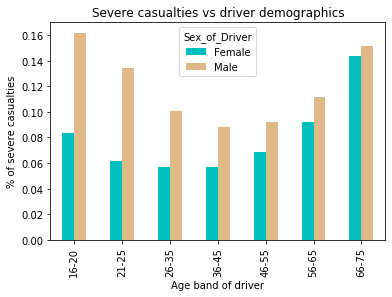

In [10]:
unique_age_sex = df_age_sex[['Sex_of_Driver', 'Age_Band_of_Driver', 'Accident_Count', 'Severe_Casualty_Count', 'Severe_Casualties_Per_Accident']].dropna().drop_duplicates()
unique_age_sex = unique_age_sex[(unique_age_sex.Age_Band_of_Driver != '11-15') & (unique_age_sex.Age_Band_of_Driver != '6-10') & (unique_age_sex.Age_Band_of_Driver != 'Over 75')]
unique_age_sex = unique_age_sex[['Sex_of_Driver', 'Age_Band_of_Driver', 'Severe_Casualties_Per_Accident']]
unique_age_sex = unique_age_sex.pivot(index='Age_Band_of_Driver', columns='Sex_of_Driver', values='Severe_Casualties_Per_Accident').reset_index()
#unique_age_sex.sort_values(by='Severe_Casualties_Per_Accident')
plt = unique_age_sex.plot(x='Age_Band_of_Driver',
                    kind='bar',
                    color = ['c', 'burlywood'],
                    title='Severe casualties vs driver demographics')
plt.set_ylabel("% of severe casualties")
plt.set_xlabel("Age band of driver")
#unique_age_sex.drop(columns=['Sex_of_Driver'])
# unique_age_sex.plot(kind='bar',
#                     x='Age_Band_of_Driver')                         

### Sepatating by weather conditions

In [7]:
df_weather = pd.merge(df_vehicles_casualties, df_uk_accidents, on = ['Accident_Index'], how='left')
df_weather = df_weather[df_weather.Weather_Conditions.notnull()]
df_weather_grouped = df_weather.groupby(['Weather_Conditions'])
for name, group in df_weather_grouped:
    df_weather.loc[(df_weather['Weather_Conditions'] == name), 'Severe_Casualties_Per_Accident'] = len(group[(group.Casualty_Severity == 'Serious') | (group.Casualty_Severity == 'Fatal')]) / len(group.Accident_Index.unique())
    df_weather.loc[(df_weather['Weather_Conditions'] == name), 'Accident_Count'] = len(group.Accident_Index.unique())
    df_weather.loc[(df_weather['Weather_Conditions'] == name), 'Severe_Casualty_Count'] = len(group[(group.Casualty_Severity == 'Serious') | (group.Casualty_Severity == 'Fatal')])

Text(0.5, 0, 'Weather conditions')

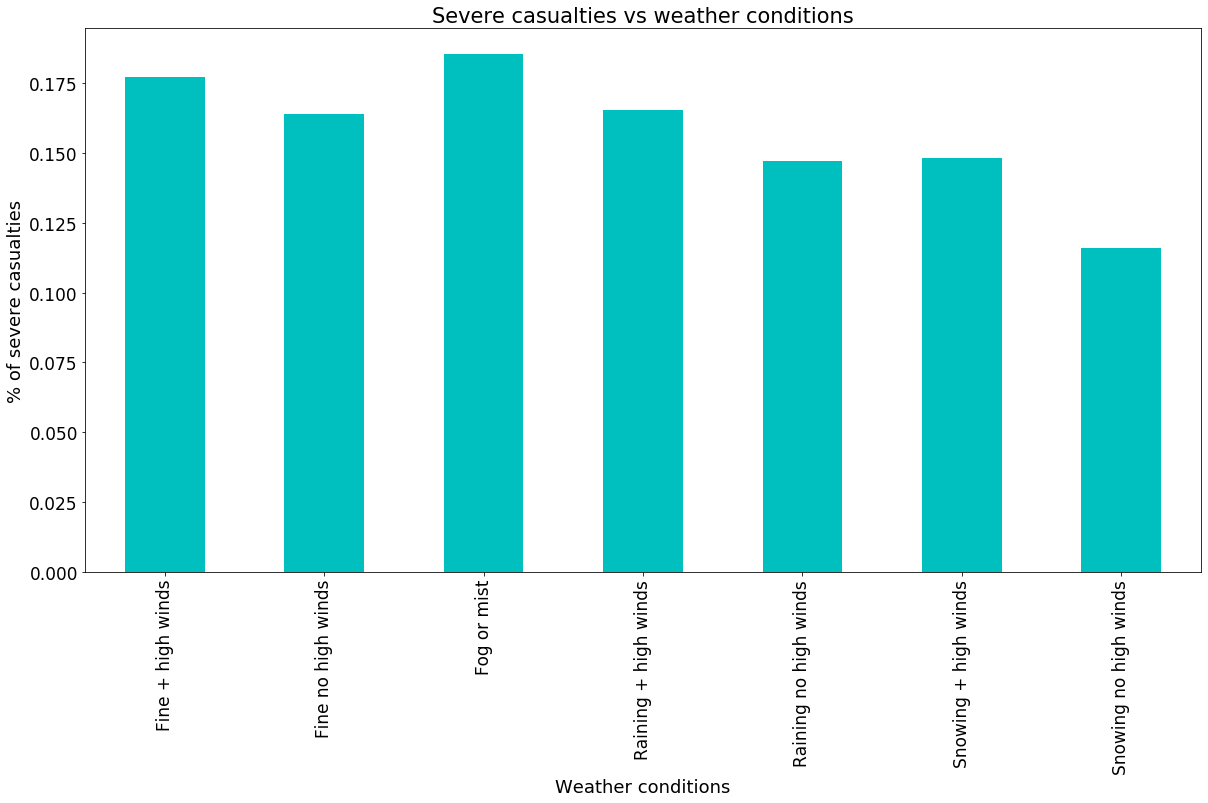

In [11]:
df_weather_sev = df_weather[['Weather_Conditions', 'Severe_Casualties_Per_Accident']].dropna().drop_duplicates()

df_weather_sev = df_weather_sev.sort_values(by='Weather_Conditions')
plt = df_weather_sev.plot(x='Weather_Conditions',
                    kind='bar',
                    color = 'c',
                    legend = False,
                    title='Severe casualties vs weather conditions')
plt.set_ylabel("% of severe casualties")
plt.set_xlabel("Weather conditions")

### Separating by Engine CC

In [11]:
# calculate the severe accidents per age_band/sex
# filter out pedestrians
df_veh_cc = df_vehicles_casualties[df_vehicles_casualties.Casualty_Class != 'Pedestrian']
df_veh_cc = df_age_sex[(df_age_sex.Vehicle_Model.notnull()) & (df_age_sex.Vehicle_Make.notnull()) & (df_age_sex['Engine_Capacity_(CC)'].notnull())]
custom_bucket_array = np.linspace(0, 500, 10)
bins = [0, 1000, 2000, 3000, 4000, 5000, np.inf]
names = []
df_veh_cc['Engine_Capacity_(CC)'] = pd.cut(df_veh_cc['Engine_Capacity_(CC)'], bins, names)
df_veh_cc_grouped = df_veh_cc.groupby(['Engine_Capacity_(CC)'])
for name, group in df_veh_cc_grouped:
    df_veh_cc.loc[(df_veh_cc['Engine_Capacity_(CC)'] == name), 'Severe_Casualties_Per_Accident'] = len(group[(group.Casualty_Severity == 'Serious') | (group.Casualty_Severity == 'Fatal')]) / len(group.Accident_Index.unique())
    df_veh_cc.loc[(df_veh_cc['Engine_Capacity_(CC)'] == name), 'Accident_Count'] = len(group.Accident_Index.unique())
    df_veh_cc.loc[(df_veh_cc['Engine_Capacity_(CC)'] == name), 'Severe_Casualty_Count'] = len(group[(group.Casualty_Severity == 'Serious') | (group.Casualty_Severity == 'Fatal')])

/home/tarek/L4L/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/tarek/L4L/.venv/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Text(0.5, 0, 'Engine capacity (CC)')

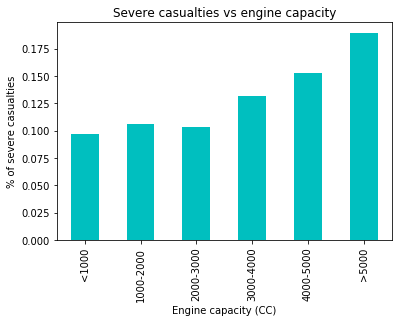

In [12]:
df_veh_cc_sev = df_veh_cc[['Engine_Capacity_(CC)', 'Severe_Casualties_Per_Accident']].dropna().drop_duplicates()

#df_veh_cc_sev = df_veh_cc_sev.reset_index().drop(index = 6)
df_veh_cc_sev = df_veh_cc_sev[['Engine_Capacity_(CC)', 'Severe_Casualties_Per_Accident']]
df_veh_cc_sev = df_veh_cc_sev.sort_values(by='Engine_Capacity_(CC)')
df_veh_cc_sev['Engine_Capacity_(CC)'] = df_veh_cc_sev['Engine_Capacity_(CC)'].astype(str)
df_veh_cc_sev['Engine_Capacity_(CC)'].replace('[0.0, 1000.0)', '<1000', inplace = True)
df_veh_cc_sev['Engine_Capacity_(CC)'].replace('[1000.0, 2000.0)', '1000-2000', inplace = True)
df_veh_cc_sev['Engine_Capacity_(CC)'].replace('[2000.0, 3000.0)', '2000-3000', inplace = True)
df_veh_cc_sev['Engine_Capacity_(CC)'].replace('[3000.0, 4000.0)', '3000-4000', inplace = True)
df_veh_cc_sev['Engine_Capacity_(CC)'].replace('[4000.0, 5000.0)', '4000-5000', inplace = True)
df_veh_cc_sev['Engine_Capacity_(CC)'].replace('[5000.0, inf)', '>5000', inplace = True)
plt = df_veh_cc_sev.plot(x='Engine_Capacity_(CC)',
                    kind='bar',
                    color = 'c',
                    legend = False,
                    title='Severe casualties vs engine capacity')
plt.set_ylabel("% of severe casualties")
plt.set_xlabel("Engine capacity (CC)")

### Correlations

In [ ]:
df_vehicles_grouped = df_uk_vehicles.groupby(['Vehicle_Make', 'Vehicle_Model']).agg('mean').reset_index()[['Vehicle_Year', 'Vehicle_Make', 'Vehicle_Model', 'Junction_Location', 'Age_of_Driver', 'Engine_Capacity_(CC)', 'Age_of_Vehicle']]
df_vehicles_severe = df_severe_casualties.merge(df_vehicles_grouped, on=['Vehicle_Make', 'Vehicle_Model'], how='left')

In [ ]:
df_vehicles_severe

In [ ]:
data = df_vehicles_severe.drop(columns=['Age_of_Vehicle'])
#data = data.rename(columns={'Vehicle_Year': 'VEHICLE_YEAR'})
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr(method='spearman')['Severe_Casualties_Per_Accident'].to_frame()
corr = corr.drop(['Severe_Casualties_Per_Accident'])
plot = sns.heatmap(corr, cmap=sns.diverging_palette(250, 40, as_cmap=True),
            square=True, annot=True,fmt='.3f', vmin=-1, vmax=1, ax=ax)
plot.set_title('Spearman\'s correlations')
bottom, top = plot.get_ylim()
plot.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
df_uk_vehicles['Sex_of_Driver']

### NCAP rating vs severe casualties

In [12]:
df_vehicles_casualties = pd.merge(df_uk_casualties, df_matched_vehicles, on = ['Accident_Index', 'Vehicle_Reference'], how='left')

df_casualty_cars = df_vehicles_casualties[(df_vehicles_casualties.Vehicle_Model.notnull()) & (df_vehicles_casualties.Vehicle_Make.notnull())]
df_casualty_cars = df_casualty_cars[(df_casualty_cars.Casualty_Severity == 'Serious') | (df_casualty_cars.Casualty_Severity == 'Fatal')]
df_casualty_cars = df_casualty_cars[['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year', 'Casualty_Severity']]

accidents_per_car = df_matched_vehicles[['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year', 'Accident_Index']].groupby(['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year']).count().reset_index()
accidents_per_car.columns = ['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year', 'Accident_Count']

casualties_per_car = df_casualty_cars[['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year', 'Casualty_Severity']].groupby(['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year']).count().reset_index()
casualties_per_car.columns = ['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year', 'Severe_Casualty_Count']

df_severe_matched = pd.merge(accidents_per_car, casualties_per_car, on=['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year'])
df_severe_matched['Severe_Casualties_Per_Accident'] = df_severe_matched.Severe_Casualty_Count / df_severe_matched.Accident_Count
df_severe_matched = df_severe_matched.sort_values(by='Accident_Count', ascending = False)

df_severe_matched

,Vehicle_Make,Vehicle_Model,Vehicle_Year,Accident_Count,Severe_Casualty_Count,Severe_Casualties_Per_Accident
241,FORD,FOCUS,2006,3389,222,0.066
240,FORD,FOCUS,2005,3062,191,0.062
243,FORD,FOCUS,2008,2914,186,0.064
242,FORD,FOCUS,2007,2881,142,0.049
244,FORD,FOCUS,2009,2669,154,0.058
916,VOLKSWAGEN,GOLF,2003,2650,176,0.066
239,FORD,FOCUS,2004,2582,200,0.077
917,VOLKSWAGEN,GOLF,2004,2382,146,0.061
238,FORD,FOCUS,2003,2347,190,0.081
918,VOLKSWAGEN,GOLF,2005,2250,124,0.055


In [13]:
df_severe_matched = df_severe_matched.sort_values(by='Severe_Casualties_Per_Accident', ascending = False)
display(df_severe_matched[df_severe_matched.Accident_Count >= 100].head(11))

,Vehicle_Make,Vehicle_Model,Vehicle_Year,Accident_Count,Severe_Casualty_Count,Severe_Casualties_Per_Accident
739,SUBARU,IMPREZA,2002,141,28,0.199
740,SUBARU,IMPREZA,2003,145,28,0.193
123,BMW,328I,1997,149,26,0.174
297,HONDA,CIVIC,1991,134,22,0.164
738,SUBARU,IMPREZA,1997,101,16,0.158
253,FORD,FUSION,2008,335,47,0.140
731,SUBARU,FORESTER,2003,100,14,0.140
800,SUZUKI,VITARA,2005,202,27,0.134
774,SUZUKI,GRAND VITARA,2005,202,27,0.134
280,HONDA,ACCORD,1995,158,21,0.133


In [14]:
df_severe_matched = df_severe_matched.sort_values(by='Severe_Casualties_Per_Accident', ascending = True)
display(df_severe_matched[df_severe_matched.Accident_Count >= 100].head(11))

,Vehicle_Make,Vehicle_Model,Vehicle_Year,Accident_Count,Severe_Casualty_Count,Severe_Casualties_Per_Accident
1038,VOLVO,V50,2007,145,1,0.007
21,AUDI,A4,2012,239,2,0.008
1004,VOLVO,S40,2007,105,1,0.010
984,VOLVO,C30,2008,128,2,0.016
154,BMW,X5,2009,115,2,0.017
1022,VOLVO,S80,2000,114,2,0.018
81,AUDI,Q7,2008,113,2,0.018
974,VOLKSWAGEN,TOUAREG,2007,105,2,0.019
142,BMW,X3,2006,202,4,0.020
151,BMW,X5,2006,142,3,0.021


In [15]:
df_ncap_ratings = pd.read_csv('final_ratings.csv', encoding = 'unicode_escape')
df_ratings_proc = df_ncap_ratings[['MAKE', 'MODEL', 'MODEL_YR', 'OVERALL_STARS', 'OVERALL_FRNT_STARS', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'SIDE_POLE_STARS', 'ROLLOVER_STARS', 'ROLLOVER_POSSIBILITY', 'COMPLAINTS_COUNT', 'RECALLS_COUNT', 'INVESTIGATIONS_COUNT']]
df_ratings_proc = df_ratings_proc.replace('Not Rated', np.nan)
df_ratings_proc[['OVERALL_STARS', 'OVERALL_FRNT_STARS', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'SIDE_POLE_STARS', 'ROLLOVER_STARS', 'ROLLOVER_POSSIBILITY', 'COMPLAINTS_COUNT', 'RECALLS_COUNT', 'INVESTIGATIONS_COUNT']] = df_ratings_proc[['OVERALL_STARS', 'OVERALL_FRNT_STARS', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'SIDE_POLE_STARS', 'ROLLOVER_STARS', 'ROLLOVER_POSSIBILITY', 'COMPLAINTS_COUNT', 'RECALLS_COUNT', 'INVESTIGATIONS_COUNT']].astype(float)
df_ratings_proc.ROLLOVER_POSSIBILITY = df_ratings_proc.ROLLOVER_POSSIBILITY.replace(0, np.nan)
display(df_ratings_proc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1588 entries, 0 to 1587
Data columns (total 16 columns):
MAKE                    1588 non-null object
MODEL                   1588 non-null object
MODEL_YR                1588 non-null int64
OVERALL_STARS           209 non-null float64
OVERALL_FRNT_STARS      214 non-null float64
FRNT_DRIV_STARS         962 non-null float64
FRNT_PASS_STARS         962 non-null float64
OVERALL_SIDE_STARS      216 non-null float64
SIDE_DRIV_STARS         783 non-null float64
SIDE_PASS_STARS         700 non-null float64
SIDE_POLE_STARS         217 non-null float64
ROLLOVER_STARS          516 non-null float64
ROLLOVER_POSSIBILITY    463 non-null float64
COMPLAINTS_COUNT        1588 non-null float64
RECALLS_COUNT           1588 non-null float64
INVESTIGATIONS_COUNT    1588 non-null float64
dtypes: float64(13), int64(1), object(2)
memory usage: 198.6+ KB


None

In [16]:
df_ratings_n = df_ratings_proc.copy(deep=True)
df_years_grouped = df_ratings_n.groupby('MODEL_YR')
normalized_cols = ['OVERALL_STARS', 'OVERALL_FRNT_STARS', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'SIDE_POLE_STARS', 'ROLLOVER_STARS']
for year, group in df_years_grouped:
    for col in normalized_cols:
        df_ratings_n.loc[df_ratings_n['MODEL_YR'] == year, col] = (df_ratings_n[df_ratings_n.MODEL_YR == year][col]-df_ratings_n[df_ratings_n.MODEL_YR == year][col].min())/(df_ratings_n[df_ratings_n.MODEL_YR == year][col].max()-df_ratings_n[df_ratings_n.MODEL_YR == year][col].min()) * 5

In [17]:
display(pd.DataFrame([df_ratings_n.FRNT_DRIV_STARS, df_ratings_proc.FRNT_DRIV_STARS]))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

Text(0, 0.5, 'Average rating')

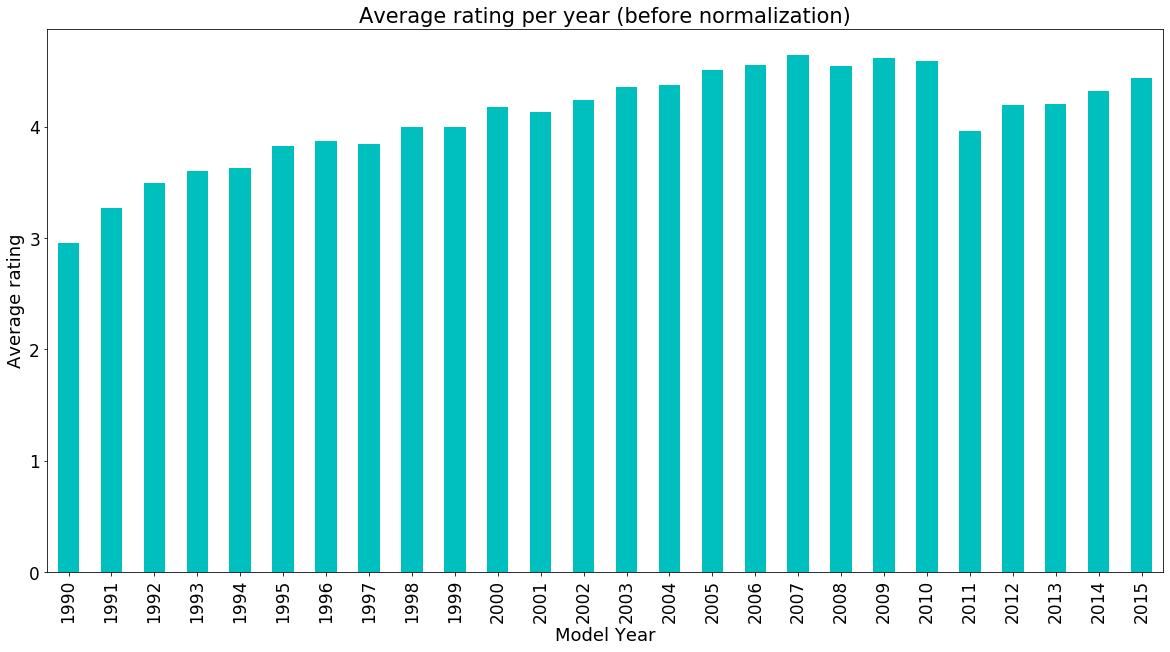

In [18]:
temp_df = df_ratings_proc.groupby('MODEL_YR').agg('mean').reset_index()
temp_df['Average_Rating'] = (temp_df.FRNT_DRIV_STARS.fillna(0) + temp_df.FRNT_PASS_STARS.fillna(0)) / 2
plt = temp_df[['MODEL_YR', 'Average_Rating']].plot(kind='bar', x = 'MODEL_YR', color = 'c', 
                                             title = 'Average rating per year (before normalization)',
                                             legend = False)
plt.set_xlabel("Model Year")
plt.set_ylabel("Average rating")

Text(0, 0.5, 'Average rating')

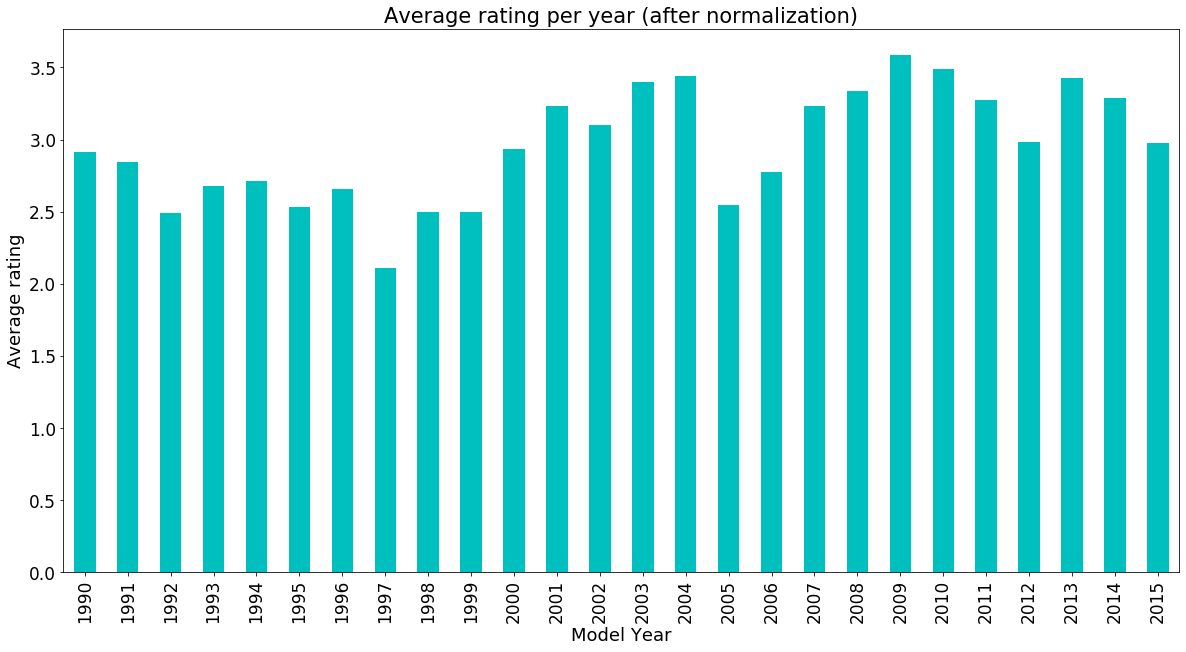

In [19]:
temp_df = df_ratings_n.groupby('MODEL_YR').agg('mean').reset_index()
temp_df['Average_Rating'] = (temp_df.FRNT_DRIV_STARS.fillna(0) + temp_df.FRNT_PASS_STARS.fillna(0)) / 2
plt = temp_df[['MODEL_YR', 'Average_Rating']].plot(kind='bar', x = 'MODEL_YR', color = 'c', 
                                             title = 'Average rating per year (after normalization)',
                                             legend = False)
plt.set_xlabel("Model Year")
plt.set_ylabel("Average rating")

In [20]:
minimized_ratings = df_ratings_n[['MAKE', 'MODEL', 'MODEL_YR', 'OVERALL_STARS', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'ROLLOVER_STARS', 'ROLLOVER_POSSIBILITY', 'COMPLAINTS_COUNT', 'RECALLS_COUNT', 'INVESTIGATIONS_COUNT']]
minimized_ratings

,MAKE,MODEL,MODEL_YR,OVERALL_STARS,FRNT_DRIV_STARS,FRNT_PASS_STARS,SIDE_DRIV_STARS,SIDE_PASS_STARS,ROLLOVER_STARS,ROLLOVER_POSSIBILITY,COMPLAINTS_COUNT,RECALLS_COUNT,INVESTIGATIONS_COUNT
0,AUDI,100,1990,nan,5.000,5.000,nan,nan,nan,nan,5.000,4.000,2.000
1,BMW,325I,1990,nan,2.500,nan,nan,nan,nan,nan,12.000,2.000,1.000
2,HONDA,PRELUDE,1990,nan,0.000,3.333,nan,nan,nan,nan,4.000,1.000,0.000
3,ISUZU,TROOPER,1990,nan,0.000,0.000,nan,nan,nan,nan,28.000,3.000,7.000
4,NISSAN,MAXIMA,1990,nan,2.500,5.000,nan,nan,nan,nan,107.000,4.000,1.000
5,SUBARU,LEGACY,1990,nan,2.500,5.000,nan,nan,nan,nan,84.000,4.000,3.000
6,TOYOTA,CELICA,1990,nan,2.500,5.000,nan,nan,nan,nan,30.000,2.000,0.000
7,TOYOTA,COROLLA,1990,nan,2.500,1.667,nan,nan,nan,nan,28.000,1.000,0.000
8,VOLKSWAGEN,PASSAT,1990,nan,1.250,5.000,nan,nan,nan,nan,35.000,2.000,0.000
9,AUDI,100,1991,nan,5.000,3.750,nan,nan,nan,nan,10.000,4.000,1.000


In [21]:
df_severe_matched

,Vehicle_Make,Vehicle_Model,Vehicle_Year,Accident_Count,Severe_Casualty_Count,Severe_Casualties_Per_Accident
1038,VOLVO,V50,2007,145,1,0.007
21,AUDI,A4,2012,239,2,0.008
1004,VOLVO,S40,2007,105,1,0.010
986,VOLVO,C30,2010,99,1,0.010
184,CHRYSLER,PT CRUISER,2006,76,1,0.013
970,VOLKSWAGEN,TIGUAN,2015,76,1,0.013
1050,VOLVO,V70,2009,68,1,0.015
984,VOLVO,C30,2008,128,2,0.016
96,AUDI,S4,2004,60,1,0.017
154,BMW,X5,2009,115,2,0.017


In [22]:
minimized_ratings_copy = minimized_ratings.copy(deep=False)
minimized_ratings_copy = minimized_ratings_copy.rename(columns={'MAKE': 'Vehicle_Make', 'MODEL': 'Vehicle_Model', 'MODEL_YR': 'Vehicle_Year'})
df_ncap_uk = df_severe_matched.merge(minimized_ratings_copy, on = ['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year'], how = 'left')
df_ncap_uk[df_ncap_uk.Accident_Count> 80]

,Vehicle_Make,Vehicle_Model,Vehicle_Year,Accident_Count,Severe_Casualty_Count,Severe_Casualties_Per_Accident,OVERALL_STARS,FRNT_DRIV_STARS,FRNT_PASS_STARS,SIDE_DRIV_STARS,SIDE_PASS_STARS,ROLLOVER_STARS,ROLLOVER_POSSIBILITY,COMPLAINTS_COUNT,RECALLS_COUNT,INVESTIGATIONS_COUNT
0,VOLVO,V50,2007,145,1,0.007,nan,nan,nan,nan,nan,nan,nan,6.000,2.000,0.000
1,AUDI,A4,2012,239,2,0.008,3.333,0.000,2.500,3.333,5.000,5.000,0.099,16.000,0.000,0.000
2,VOLVO,S40,2007,105,1,0.010,nan,0.000,5.000,5.000,5.000,nan,nan,21.000,2.000,0.000
3,VOLVO,C30,2010,99,1,0.010,nan,nan,nan,nan,nan,nan,nan,4.000,2.000,0.000
7,VOLVO,C30,2008,128,2,0.016,nan,nan,nan,nan,nan,nan,nan,8.000,2.000,0.000
9,BMW,X5,2009,115,2,0.017,nan,5.000,2.500,5.000,5.000,2.500,0.174,106.000,14.000,0.000
10,VOLVO,S80,2000,114,2,0.018,nan,nan,nan,5.000,5.000,nan,nan,339.000,5.000,2.000
11,AUDI,Q7,2008,113,2,0.018,nan,5.000,5.000,5.000,5.000,2.500,0.185,20.000,2.000,0.000
14,VOLKSWAGEN,TOUAREG,2007,105,2,0.019,nan,5.000,5.000,5.000,5.000,3.333,0.169,8.000,3.000,0.000
16,BMW,X3,2006,202,4,0.020,nan,nan,nan,nan,nan,nan,nan,302.000,4.000,2.000


In [23]:
data = df_ncap_uk[df_ncap_uk.Accident_Count > 80].drop(columns=['Vehicle_Make', 'Vehicle_Model', 'Severe_Casualty_Count', 'Accident_Count'])
data = data.rename(columns={'Vehicle_Year': 'VEHICLE_YEAR', 'Severe_Casualties_Per_Accident': '%_Severe_Casualties'})
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr(method='spearman')['%_Severe_Casualties'].to_frame()
corr = corr.drop(['%_Severe_Casualties'])
plot = sns.heatmap(corr, cmap=sns.diverging_palette(250, 40, as_cmap=True),
            square=True, annot=True,fmt='.3f', vmin=-1, vmax=1, ax=ax)
plot.set_title('Spearman\'s correlation (normalized ratings)')
bottom, top = plot.get_ylim()
plot.set_ylim(bottom + 0.5, top - 0.5)


AttributeError: 'AxesSubplot' object has no attribute 'subplots'

In [ ]:
print ('Spearman Corr.')
print('# of distict car ratings:', len(data))
print('# of accidents:', df_ncap_uk.Accident_Count.sum())

In [ ]:
df_ncap_uk_grouped = df_ncap_uk[(df_ncap_uk.Accident_Count > 80)].drop(columns=['Severe_Casualty_Count', 'Accident_Count'])
df_ncap_uk_grouped = df_ncap_uk_grouped.groupby(['Vehicle_Make', 'Vehicle_Model']).agg('mean').reset_index()

In [ ]:
df_ncap_uk_grouped = df_ncap_uk_grouped.sort_values(by='Severe_Casualties_Per_Accident')
data = df_ncap_uk_grouped.drop(columns=['Vehicle_Make', 'Vehicle_Year', 'COMPLAINTS_COUNT', 'RECALLS_COUNT', 'INVESTIGATIONS_COUNT', 'ROLLOVER_POSSIBILITY'])

In [ ]:
ax = data.plot(kind="scatter", x="FRNT_DRIV_STARS",y="Severe_Casualties_Per_Accident", color="m", label="Front driver", s=8)
data.plot(kind="scatter", x="FRNT_PASS_STARS",y="Severe_Casualties_Per_Accident", color="g", label="Front passenger", s=8, ax=ax)
data.plot(kind="scatter", x="OVERALL_STARS",y="Severe_Casualties_Per_Accident", color="r", label="Overall", s=8, ax=ax)
data.plot(kind="scatter", x="ROLLOVER_STARS",y="Severe_Casualties_Per_Accident", color="c", label="Rollover", s=8, ax=ax)
ax.set_ylabel("% of severe casualties")
ax.set_xlabel("Star rating (normalized)")
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('Severe casualties vs NCAP rating')

In [ ]:
print('# of distinct car ratings:', len(df_ncap_uk_grouped))

In [ ]:
print('total # of accidents:', (df_ncap_uk[(df_ncap_uk.Accident_Count > 80)].Accident_Count.sum()))

In [ ]:
data

In [ ]:
df_ncap_uk